In [1]:
%load_ext autoreload
%matplotlib inline
# %matplotlib notebook

# Isolation Forest
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

This notebook is about a first attempt using Isolation Forest on all temperature data (32 collections).

In [2]:
import os, sys
import numpy as np
import pandas as pd
from IPython.display import display
sys.path.append(os.path.abspath(os.path.join('..')))

import plot.anomalies
from plot import pyplot as plt
from database.CERNMongoClient import CERNMongoClient
from anomaly_detection.IsolationForest import IsolationForest
from evaluation import evaluation, segmentation
from feature_extraction import feature_extraction, preprocessing, PCA

db = CERNMongoClient()

# auto-load changes in imported modules
%autoreload 2

## Fetch the data

In [3]:
df = db.query(".*B1:TEMP.*", resample_to='1min')

Fetching data for pattern .*B1:TEMP.* from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.D5L2.B1:TEMP_TUBE_UP
Fetching data for MKI.C5L2.B1:TEMP_TUBE_UP
Fetching data for MKI.A5L2.B1:TEMP_MAGNET_UP
Fetching data for MKI.D5L2.B1:TEMP_MAGNET_UP
Fetching data for MKI.B5L2.B1:TEMP_TUBE_DOWN
Fetching data for MKI.A5L2.B1:TEMP_TUBE_DOWN
Fetching data for MKI.B5L2.B1:TEMP_MAGNET_DOWN
Fetching data for MKI.B5L2.B1:TEMP_TUBE_UP
Fetching data for MKI.A5L2.B1:TEMP_TUBE_UP
Fetching data for MKI.D5L2.B1:TEMP_TUBE_DOWN
Fetching data for MKI.C5L2.B1:TEMP_MAGNET_UP
Fetching data for MKI.C5L2.B1:TEMP_MAGNET_DOWN
Fetching data for MKI.B5L2.B1:TEMP_MAGNET_UP
Fetching data for MKI.C5L2.B1:TEMP_TUBE_DOWN
Fetching data for MKI.D5L2.B1:TEMP_MAGNET_DOWN
Fetching data for MKI.A5L2.B1:TEMP_MAGNET_DOWN


In [4]:
display(df.shape)
display(df.head())
display(df.describe())

(215991, 16)

series               MKI.D5L2.B1:TEMP_TUBE_UP  MKI.C5L2.B1:TEMP_TUBE_UP  \
timestamps                                                                
2016-04-16 22:09:00                      23.8                      23.6   
2016-04-16 22:10:00                      23.8                      23.6   
2016-04-16 22:11:00                      23.8                      23.6   
2016-04-16 22:12:00                      23.8                      23.6   
2016-04-16 22:13:00                      23.8                      23.6   

series               MKI.A5L2.B1:TEMP_MAGNET_UP  MKI.D5L2.B1:TEMP_MAGNET_UP  \
timestamps                                                                    
2016-04-16 22:09:00                        21.0                        23.8   
2016-04-16 22:10:00                        21.0                        23.8   
2016-04-16 22:11:00                        21.0                        23.8   
2016-04-16 22:12:00                        21.0                        23.8   
2016-04-16 22:13:00                        21.0                        23.8   

series               MKI.B5L2.B1:TEMP_TUBE_DOWN  MKI.A5L2.B1:TEMP_TUBE_DOWN  \
timestamps                                                                    
2016-04-16 22:09:00                        21.0                        22.1   
2016-04-16 22:10:00                        21.0                        22.1   
2016-04-16 22:11:00                        21.0                        22.1   
2016-04-16 22:12:00                        21.0                        22.1   
2016-04-16 22:13:00                        21.0                        22.1   

series               MKI.B5L2.B1:TEMP_MAGNET_DOWN  MKI.B5L2.B1:TEMP_TUBE_UP  \
timestamps                                                                    
2016-04-16 22:09:00                          20.7                      21.0   
2016-04-16 22:10:00                          20.7                      21.0   
2016-04-16 22:11:00                          20.7                      21.0   
2016-04-16 22:12:00                          20.7                      21.0   
2016-04-16 22:13:00                          20.7                      21.0   

series               MKI.A5L2.B1:TEMP_TUBE_UP  MKI.D5L2.B1:TEMP_TUBE_DOWN  \
timestamps                                                                  
2016-04-16 22:09:00                      21.0                        24.3   
2016-04-16 22:10:00                      21.0                        24.3   
2016-04-16 22:11:00                      21.0                        24.3   
2016-04-16 22:12:00                      21.0                        24.3   
2016-04-16 22:13:00                      21.0                        24.3   

series               MKI.C5L2.B1:TEMP_MAGNET_UP  MKI.C5L2.B1:TEMP_MAGNET_DOWN  \
timestamps                                                                      
2016-04-16 22:09:00                        23.8                          24.7   
2016-04-16 22:10:00                        23.8                          24.7   
2016-04-16 22:11:00                        23.8                          24.7   
2016-04-16 22:12:00                        23.8                          24.7   
2016-04-16 22:13:00                        23.8                          24.7   

series               MKI.B5L2.B1:TEMP_MAGNET_UP  MKI.C5L2.B1:TEMP_TUBE_DOWN  \
timestamps                                                                    
2016-04-16 22:09:00                        20.3                        28.1   
2016-04-16 22:10:00                        20.3                        28.1   
2016-04-16 22:11:00                        20.3                        28.1   
2016-04-16 22:12:00                        20.3                        28.1   
2016-04-16 22:13:00                        20.3                        28.1   

series               MKI.D5L2.B1:TEMP_MAGNET_DOWN  \
timestamps                                          
2016-04-16 22:09:00                         

series  MKI.D5L2.B1:TEMP_TUBE_UP  MKI.C5L2.B1:TEMP_TUBE_UP  \
count              215991.000000              215991.00000   
mean                   49.934371                  36.82503   
std                    23.482653                  11.18187   
min                    11.800000                  11.70000   
25%                    26.900000                  25.60000   
50%                    44.700000                  35.70000   
75%                    72.800000                  47.20000   
max                   101.400000                  62.00000   

series  MKI.A5L2.B1:TEMP_MAGNET_UP  MKI.D5L2.B1:TEMP_MAGNET_UP  \
count                 215991.00000               215991.000000   
mean                      32.12569                   34.406780   
std                        8.61807                    8.121305   
min                       10.35000                   11.800000   
25%                       23.40000                   26.300000   
50%                       32.30000                   34.800000   
75%                       40.20000                   42.000000   
max                       49.00000                   50.200000   

series  MKI.B5L2.B1:TEMP_TUBE_DOWN  MKI.A5L2.B1:TEMP_TUBE_DOWN  \
count                215991.000000               215991.000000   
mean                     29.629148                   32.278918   
std                       7.258756                    8.555466   
min                      10.350000                   10.900000   
25%                      22.500000                   23.800000   
50%                      28.100000                   30.300000   
75%                      36.800000                   40.700000   
max                      44.300000                   49.700000   

series  MKI.B5L2.B1:TEMP_MAGNET_DOWN  MKI.B5L2.B1:TEMP_TUBE_UP  \
count                  215991.000000             215991.000000   
mean                       26.835027                 36.490948   
std                         4.565428                 13.987887   
min                        10.250000                 10.350000   
25%                        22.300000                 23.800000   
50%                        27.200000                 35.000000   
75%                        31.200000                 44.100000   
max                        34.800000                 86.000000   

series  MKI.A5L2.B1:TEMP_TUBE_UP  MKI.D5L2.B1:TEMP_TUBE_DOWN  \
count              215991.000000               215991.000000   
mean                   48.713511                   34.909172   
std                    24.995272                    9.259229   
min                    10.350000                   12.050000   
25%                    24.300000                   25.800000   
50%                    42.200000                   32.300000   
75%                    73.700000                   44.100000   
max                   102.500000                   54.000000   

series  MKI.C5L2.B1:TEMP_MAGNET_UP  MKI.C5L2.B1:TEMP_MAGNET_DOWN  \
count                215991.000000                 215991.000000   
mean                     34.172725                     31.194701   
std                       7.948608                      4.754469   
min                      11.900000                     12.350000   
25%                      26.300000                     26.500000   
50%                      34.300000                     31.600000   
75%                      41.300000                     35.700000   
max                      50.400000                     39.700000   

series  MKI.B5L2.B1:TEMP_MAGNET_UP  MKI.C5L2.B1:TEMP_TUBE_DOWN  \
count                215991.000000               215991.000000   
mean                     30.529509                   39.850034   
std                       8.037167                   10.205921   
min                       9.900000                   13.900000   
25%                      22.500000                   30.100000   
50%                      30.900000                   37.000000   
75% 

## Train a model and predict on the raw data

### Fit the model and make predictions.

In [5]:
# defaults: n_estimators=100, max_samples=256, contamination=0.1, n_jobs=1, verbose=0
# 500 trees, 500 samples on PC. 250, 256 on laptop
clf = IsolationForest(n_estimators=128, max_samples=256, contamination=0.1, n_jobs=-1, verbose=1)
clf

In [6]:
# %timeit clf.fit(train_df)
clf.fit(df)
predictions = clf.predict(df)

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.5s remaining:    5.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.0s finished


Predicted anomalies:  21600
Predicted normal:     194391
Total:                215991


In [7]:
predictions

array([False, False, False, ..., False, False, False])

### Plot results

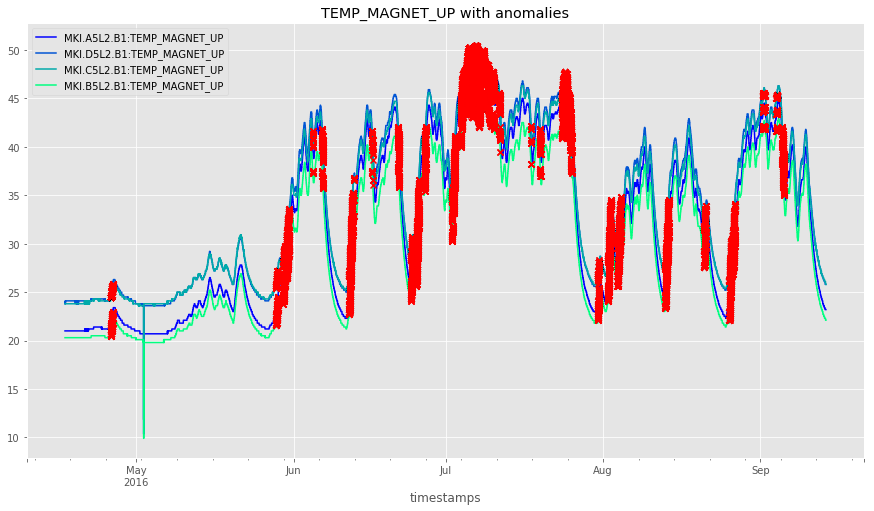

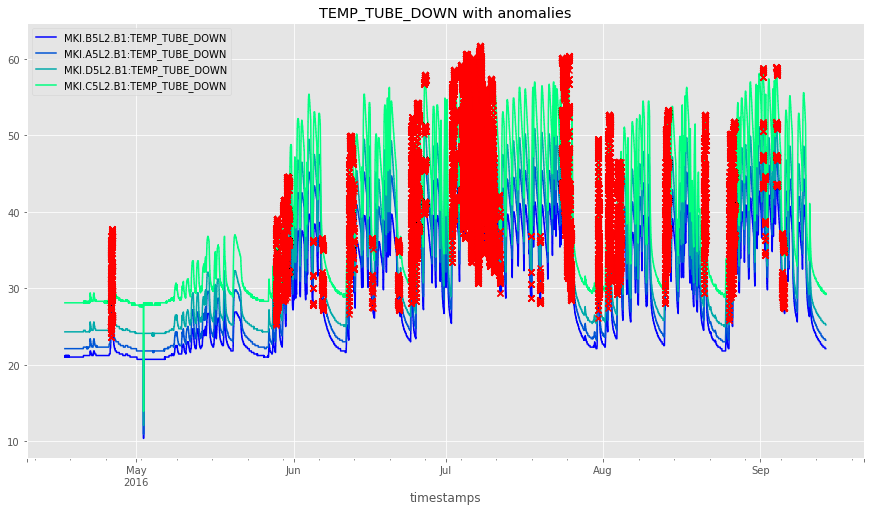

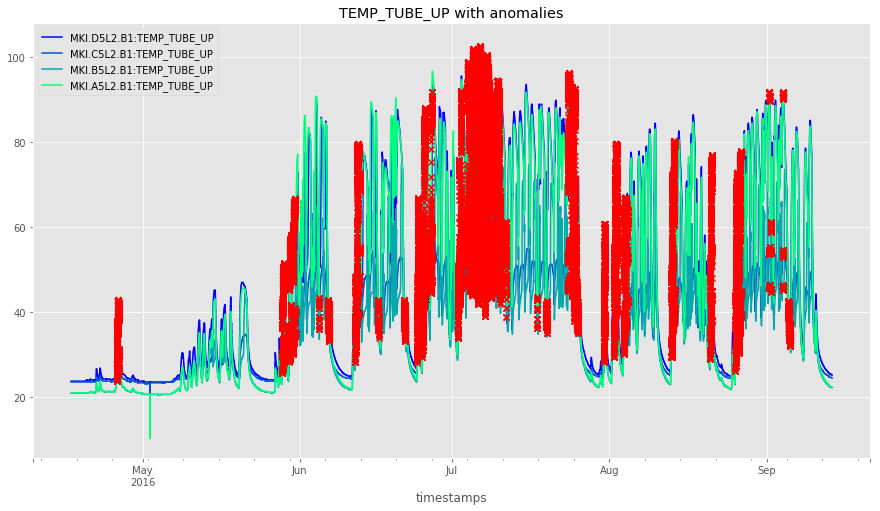

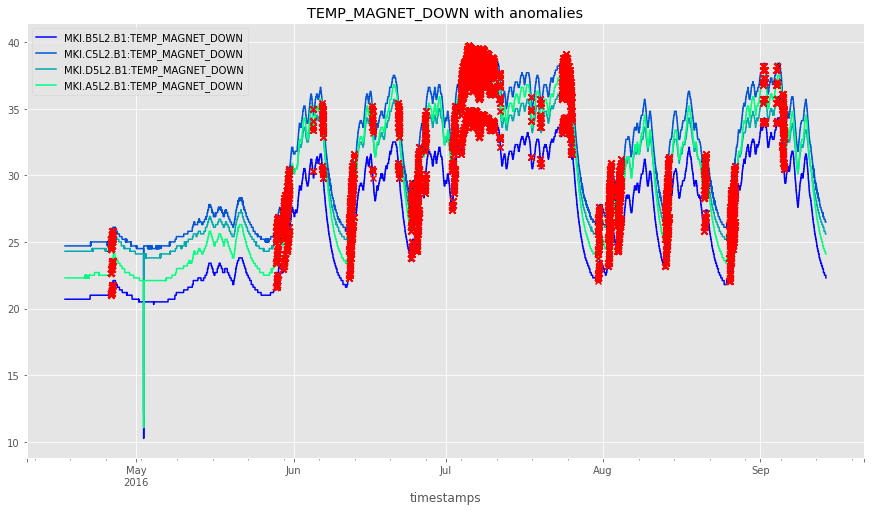

In [8]:
for measurement in ["TEMP_MAGNET_UP", "TEMP_TUBE_DOWN", "TEMP_TUBE_UP", "TEMP_MAGNET_DOWN"]:
    plot.anomalies.timeseries_anomalies(df, measurement, predictions)    

The two spikes in temperature (> 3000 degrees, only happens in beam 2 data, not beam 1 data) and the sudden drop (< 15 degrees) are spotted as anomalies, which is a good sign, but these are just wrong sensor readings.

### Anomaly scores

In [9]:
# The anomaly score of an input sample is computed as the mean anomaly score of the trees in the forest.
# The lower, the more abnormal
anomaly_scores = clf.anomaly_scores(df)

In [10]:
anomaly_df = pd.DataFrame({'score' : anomaly_scores})
display(anomaly_df.describe(), anomaly_df.head())

score
count  215991.000000
mean        0.016965
std         0.033245
min        -0.116172
25%        -0.000830
50%         0.020715
75%         0.043071
max         0.068309

score
0  0.059193
1  0.059193
2  0.059193
3  0.059193
4  0.059193

#### 1000 most anomalous points

In [11]:
most_anomalous_idx = clf.n_most_anomalous_idx(anomaly_df, 1000)
most_anomalous_scores = anomaly_df.iloc[most_anomalous_idx]
most_anomalous_points = df.iloc[most_anomalous_idx]

display(most_anomalous_scores.describe(), most_anomalous_points.describe())

score
count  1000.000000
mean     -0.104771
std       0.004808
min      -0.116172
25%      -0.108301
50%      -0.104316
75%      -0.100274
max      -0.098019

series  MKI.D5L2.B1:TEMP_TUBE_UP  MKI.C5L2.B1:TEMP_TUBE_UP  \
count                1000.000000               1000.000000   
mean                   95.830500                 60.923800   
std                     4.092641                  0.841654   
min                    88.700000                 58.300000   
25%                    92.050000                 60.600000   
50%                    96.600000                 61.100000   
75%                   100.300000                 61.500000   
max                   100.700000                 62.000000   

series  MKI.A5L2.B1:TEMP_MAGNET_UP  MKI.D5L2.B1:TEMP_MAGNET_UP  \
count                  1000.000000                 1000.000000   
mean                     48.479800                   49.687900   
std                       0.479314                    0.498731   
min                      47.500000                   48.600000   
25%                      48.100000                   49.300000   
50%                      48.800000                   49.900000   
75%                      48.800000                   50.200000   
max                      49.000000                   50.200000   

series  MKI.B5L2.B1:TEMP_TUBE_DOWN  MKI.A5L2.B1:TEMP_TUBE_DOWN  \
count                  1000.000000                 1000.000000   
mean                     41.476400                   46.187500   
std                       1.507546                    1.679457   
min                      39.300000                   43.600000   
25%                      40.000000                   44.500000   
50%                      41.100000                   46.100000   
75%                      42.900000                   47.900000   
max                      44.100000                   48.800000   

series  MKI.B5L2.B1:TEMP_MAGNET_DOWN  MKI.B5L2.B1:TEMP_TUBE_UP  \
count                    1000.000000               1000.000000   
mean                       34.673000                 63.522848   
std                         0.193671                 16.036760   
min                        34.300000                 49.500000   
25%                        34.500000                 50.200000   
50%                        34.800000                 51.300000   
75%                        34.800000                 84.200000   
max                        34.800000                 85.500000   

series  MKI.A5L2.B1:TEMP_TUBE_UP  MKI.D5L2.B1:TEMP_TUBE_DOWN  \
count                1000.000000                 1000.000000   
mean                   96.530500                   49.071400   
std                     4.386922                    2.497839   
min                    88.700000                   45.400000   
25%                    92.300000                   46.800000   
50%                    97.400000                   48.600000   
75%                   100.900000                   51.500000   
max                   101.900000                   53.300000   

series  MKI.C5L2.B1:TEMP_MAGNET_UP  MKI.C5L2.B1:TEMP_MAGNET_DOWN  \
count                  1000.000000                   1000.000000   
mean                     49.735100                     39.483600   
std                       0.665628                      0.115171   
min                      48.400000                     39.300000   
25%                      49.300000                     39.500000   
50%                      49.900000                     39.500000   
75%                      50.400000                     39.500000   
max                      50.400000                     39.700000   

series  MKI.B5L2.B1:TEMP_MAGNET_UP  MKI.C5L2.B1:TEMP_TUBE_DOWN  \
count                  1000.000000                 1000.000000   
mean                     45.595700                   55.333900   
std                       0.508222                    2.619638   
min                      44.500000                   51.800000   
25%                      45.200000                   52.900000   
50%                      45.900000                   54.700000   
75% 

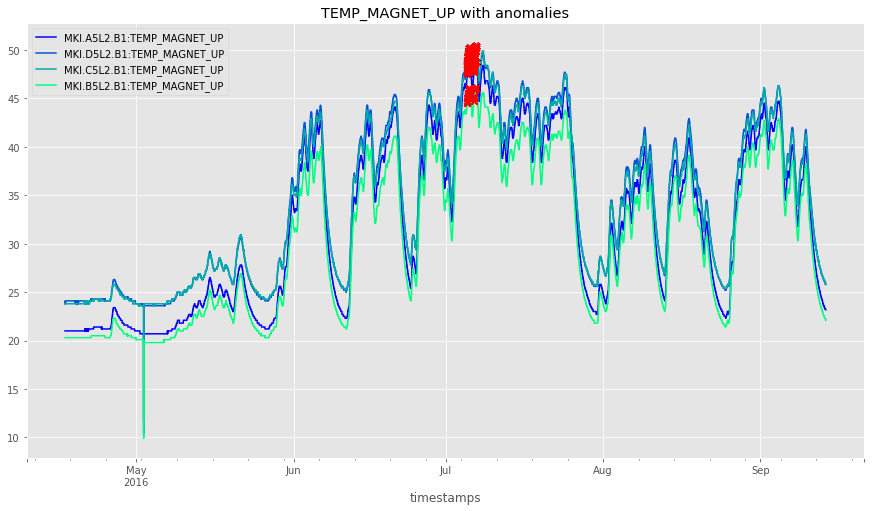

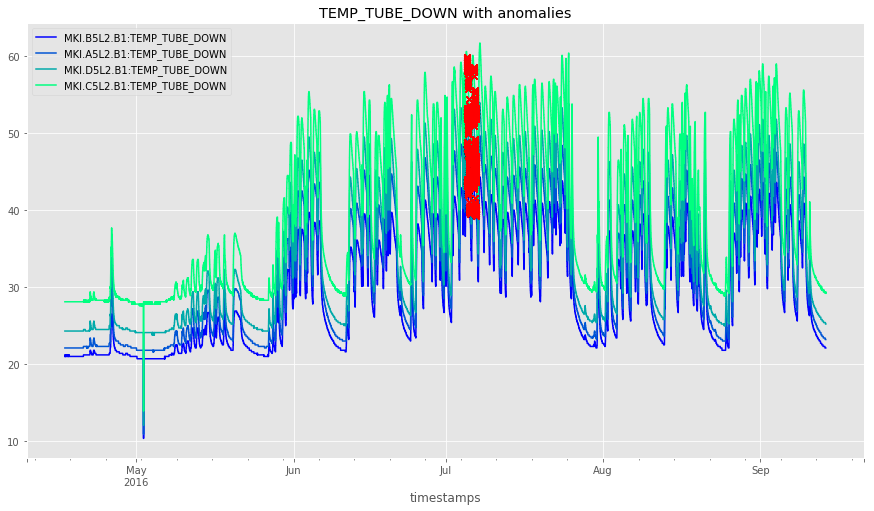

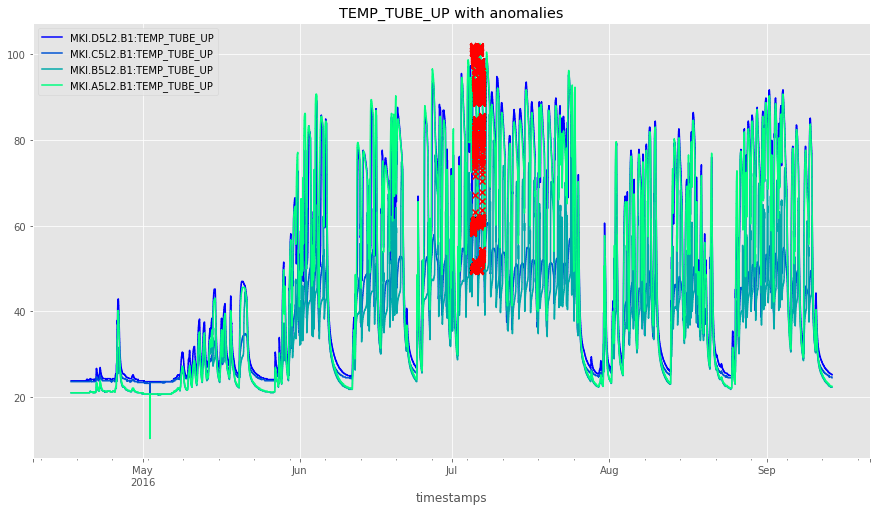

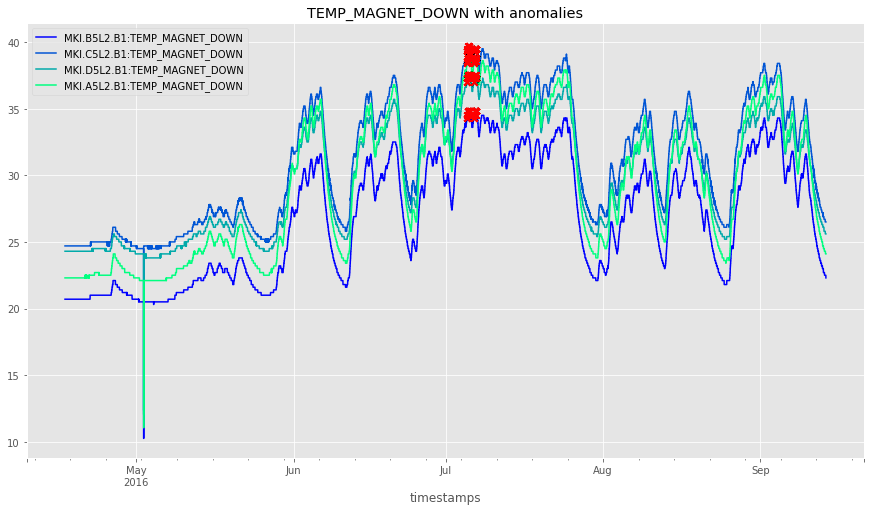

In [12]:
for measurement in ["TEMP_MAGNET_UP", "TEMP_TUBE_DOWN", "TEMP_TUBE_UP", "TEMP_MAGNET_DOWN"]:
    plot.anomalies.timeseries_anomalies(df, measurement, most_anomalous_idx)    

In [13]:
clf.iforest.get_params(True)

{'bootstrap': False,
 'contamination': 0.1,
 'max_features': 1.0,
 'max_samples': 256,
 'n_estimators': 128,
 'n_jobs': -1,
 'random_state': None,
 'verbose': 1}

In [14]:
# clf.iforest.estimators_

## Same process with filtered data

In [15]:
df = preprocessing.filter_extremes(df)
anomaly_scores = clf.fit_and_anomaly_scores(df)
anomaly_df = pd.DataFrame({ 'score': anomaly_scores})

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.8s finished


In [16]:
most_anomalous_idx = clf.n_most_anomalous_idx(anomaly_df, 1000)
most_anomalous_scores = anomaly_df.iloc[most_anomalous_idx]
most_anomalous_points = df.iloc[most_anomalous_idx]

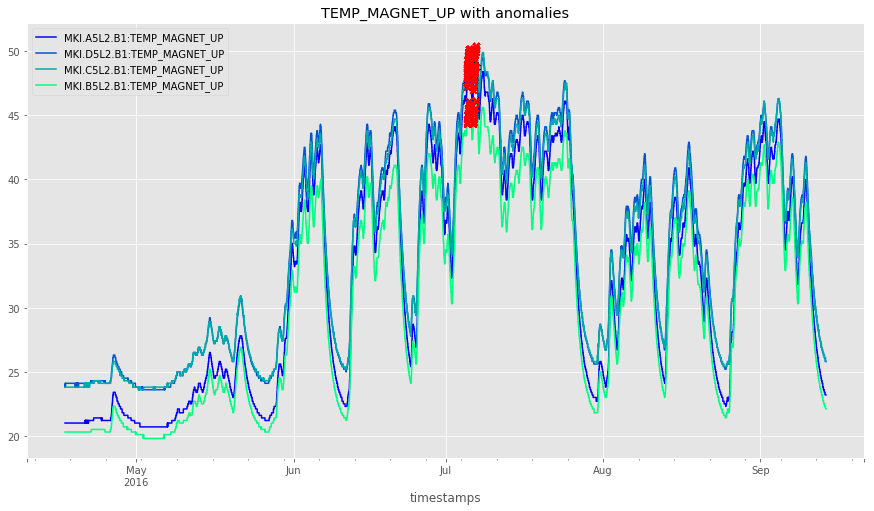

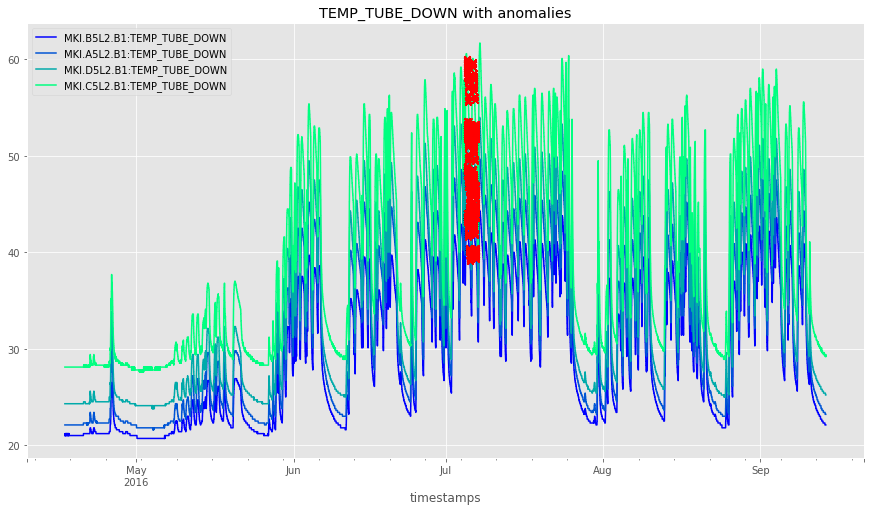

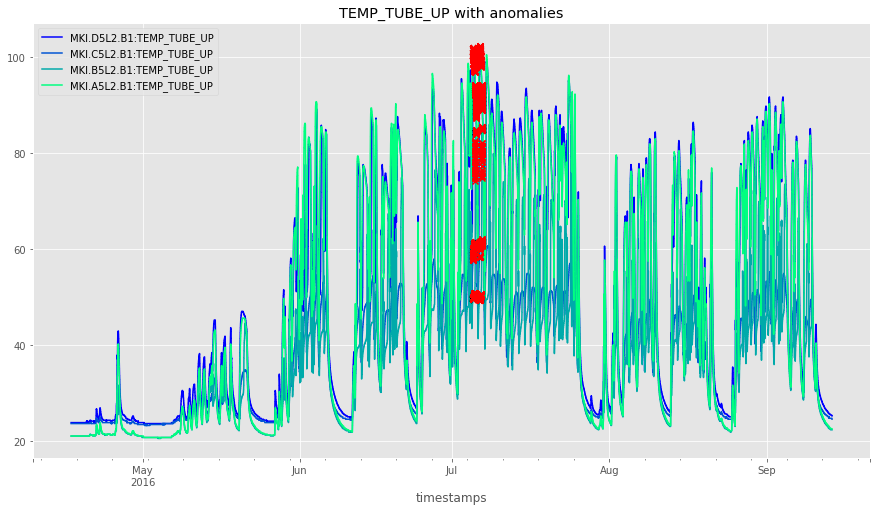

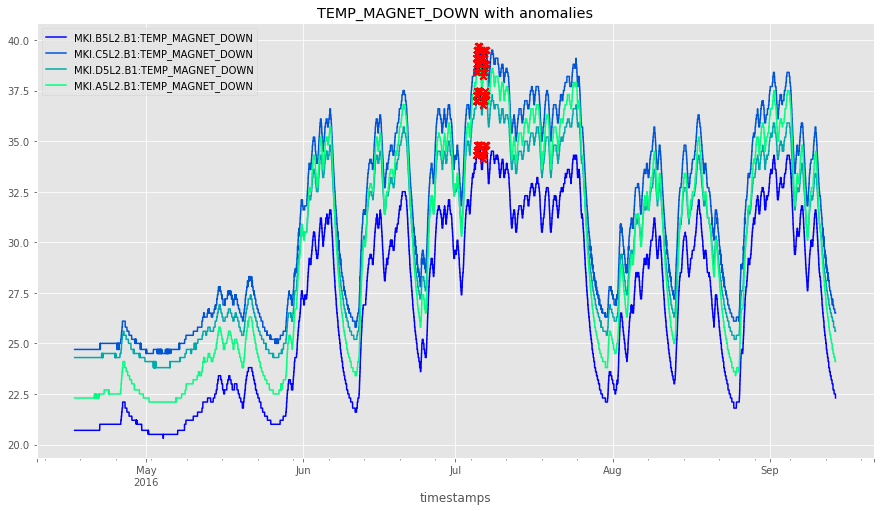

In [17]:
for measurement in ["TEMP_MAGNET_UP", "TEMP_TUBE_DOWN", "TEMP_TUBE_UP", "TEMP_MAGNET_DOWN"]:
    plot.anomalies.timeseries_anomalies(df, measurement, most_anomalous_idx)    

## B1:  Continuous + IPOC + sliding window features

Based on notebook 170323.

For the following experiments, all data is used of beam 1. The IPOC timestamps of beam 1 and 2 are not in sync. 

The dataframe is obtained by running `build_features.py`

### Fetch data

In [18]:
df = feature_extraction.load_features_from_file("features_b1_sw-30min*")
dfs = preprocessing.scale_robust(df)
display(dfs.shape, dfs.describe())

Loading file '/home/n/master-thesis/src/../data-cern/features_b1_sw-30min*'.
File not found, loading '/home/n/master-thesis/src/../data-cern/features_b1_sw-30min_2018-02-26.csv' instead.


(46090, 88)

MKI.UA23.IPOC.CB1:T_LENGTH  MKI.UA23.IPOC.AB1:T_LENGTH  \
count                46090.000000                46090.000000   
mean                     0.896352                    0.929468   
std                      4.189893                    4.418192   
min                    -42.135794                   -0.867274   
25%                     -0.002550                   -0.001997   
50%                      0.000000                    0.000000   
75%                      0.997450                    0.998003   
max                     57.370476                   57.102529   

       MKI.UA23.IPOC.AB1:E_KICK  MKI.UA23.IPOC.DB1:E_KICK  \
count              46090.000000              46090.000000   
mean                   0.019731                  0.019710   
std                    0.478232                  0.478251   
min                   -0.523308                 -0.523392   
25%                   -0.515076                 -0.515126   
50%                    0.000000                  0.000000   
75%                    0.484924                  0.484874   
max                    0.710525                  0.710531   

       MKI.UA23.IPOC.AB1:T_FALLTIME  MKI.UA23.IPOC.DB1:T_FALLTIME  \
count                  46090.000000                  46090.000000   
mean                      -0.431896                     -3.343751   
std                      182.688320                    493.942922   
min                   -12073.590476                 -12208.028846   
25%                       -0.352381                     -0.326923   
50%                        0.000000                      0.000000   
75%                        0.647619                      0.673077   
max                    11815.638095                  11946.355769   

       MKI.UA23.IPOC.AB1:T_START_TH  MKI.UA23.IPOC.CB1:E_KICK  \
count                  46090.000000              46090.000000   
mean                     161.830792                  0.019710   
std                     1311.170873                  0.478251   
min                   -13223.800000                 -0.523392   
25%                       -0.400000                 -0.515126   
50%                        0.000000                  0.000000   
75%                        0.600000                  0.484874   
max                     2100.200000                  0.710531   

       MKI.UA23.IPOC.CB1:I_STRENGTH  MKI.UA23.IPOC.BB1:T_RISETIME  \
count                  46090.000000                  46090.000000   
mean                      -0.479147                     -0.553726   
std                        1.747108                     35.933346   
min                       -8.946550                  -2768.843137   
25%                       -0.354786                     -0.098039   
50%                        0.000000                      0.000000   
75%                        0.645214                      0.901961   
max                        0.967821                   2427.235294   

                          ...                      \
count                     ...                       
mean                      ...                       
std                       ...                       
min                       ...                       
25%                       ...                       
50%                       ...                       
75%                       ...                       
max                       ...                       

       MKI.B5L2.B1:TEMP_TUBE_UP:SW_SUM_1800_s  \
count                            46090.000000   
mean                                 0.122188   
std                                  0.625962   
min                                 -0.616354   
25%                                 -0.435661   
50%                                  0.000000   
75%                                  0.564339   
max                                  1.988939   

       MKI.A5L2.B1:TEMP_TUBE_UP:SW_SUM_1800_s  \
count                            46090.000000   
mean                   

### Build the model

In [19]:
clf = IsolationForest(n_estimators=500, max_samples=256, contamination=0.1, n_jobs=-1, verbose=1)
clf

In [20]:
clf.fit(dfs)

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    9.0s remaining:    9.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    9.9s finished


In [21]:
predictions = clf.predict(dfs)

Predicted anomalies:  4609
Predicted normal:     41481
Total:                46090


In [22]:
anomaly_scores = clf.anomaly_scores(dfs)
anomaly_df = pd.DataFrame( {'score' : anomaly_scores })

### Check predictions

In [23]:
pct = np.percentile(anomaly_scores, 1)
display("1% percentile: " + str(pct))
most_anomalous_idx = np.where((anomaly_scores < pct))[0]

'1% percentile: -0.04163634535284233'

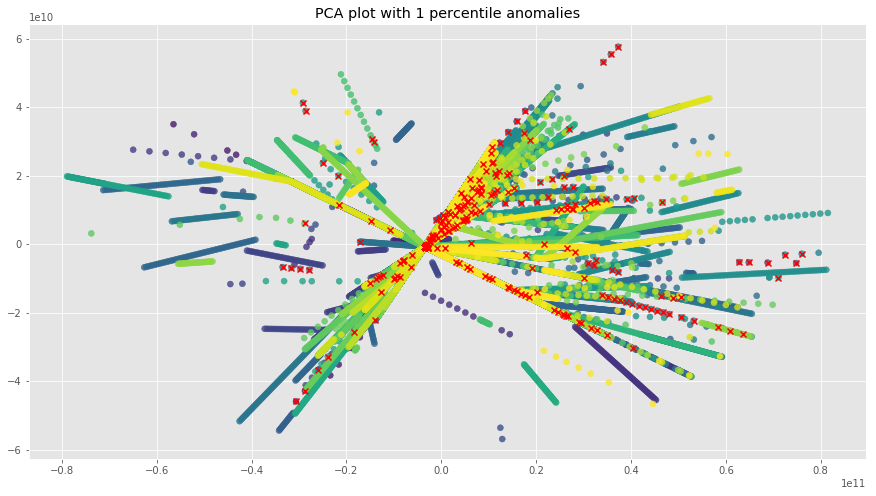

In [24]:
p = PCA.PCA(n_components=2)
p_data = p.transform(dfs)
plot.anomalies.pca_anomalies(p_data, most_anomalous_idx, "PCA plot with 1 percentile anomalies")

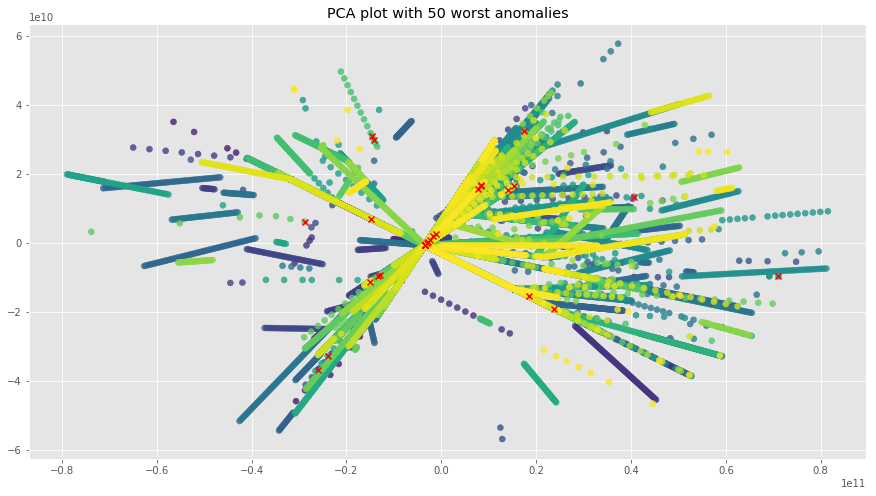

In [25]:
most_anomalous_idx = clf.n_most_anomalous_idx(anomaly_df, 50)
plot.anomalies.pca_anomalies(p_data, most_anomalous_idx, "PCA plot with 50 worst anomalies")

Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


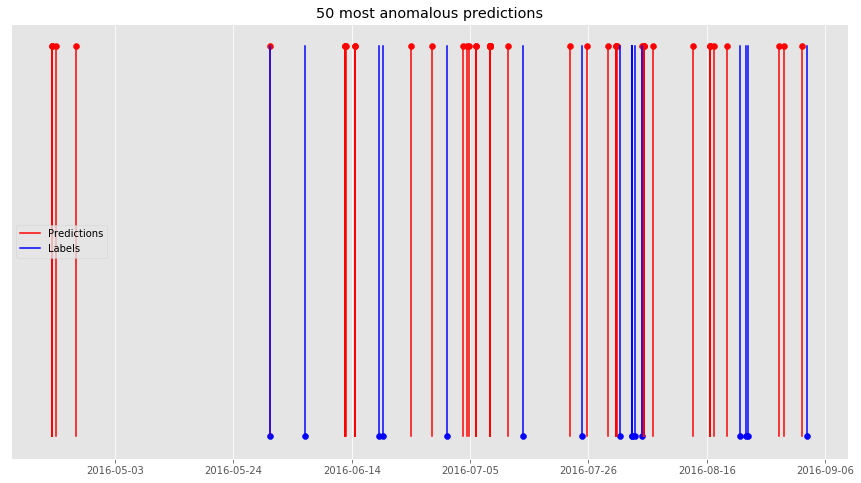

In [26]:
labels = db.query_elogbook_anomalies()
predictions = dfs.iloc[most_anomalous_idx]

plot.anomalies.labels_vs_predictions(labels, predictions, "50 most anomalous predictions")

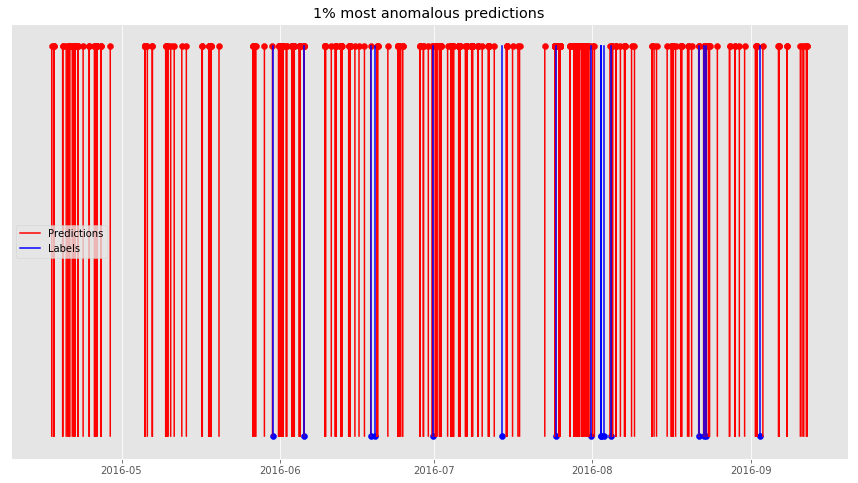

In [27]:
most_anomalous_idx = np.where((anomaly_scores < pct))[0]
predictions = dfs.iloc[most_anomalous_idx]

plot.anomalies.labels_vs_predictions(labels, predictions, "1% most anomalous predictions")

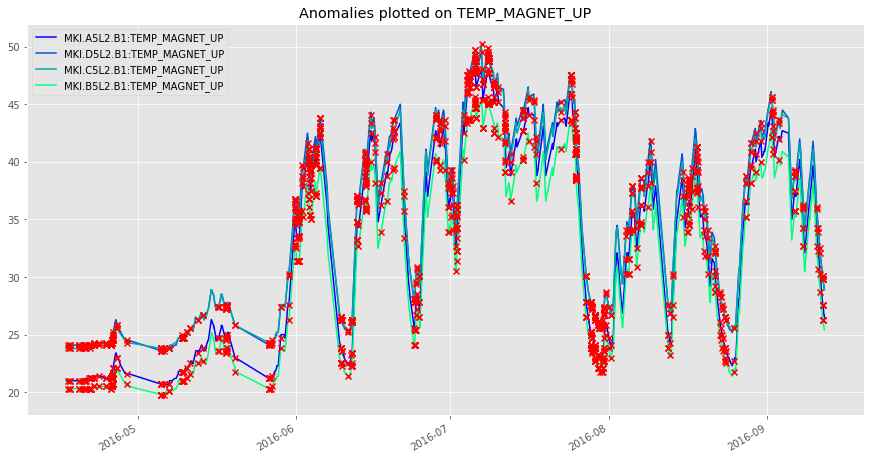

In [28]:
plot.anomalies.timeseries_anomalies(df, "TEMP_MAGNET_UP", most_anomalous_idx, "Anomalies plotted on TEMP_MAGNET_UP")